In [ ]:
import pandas as pd
import numpy as np
import joblib
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import os
import matplotlib.pyplot as plt
import shutil

In [ ]:
from google.colab import files

files.upload()




Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"helpmepeet","key":"6008b61fb922f3a5997d588dd531dcff"}'}

In [ ]:



os.makedirs("/root/.kaggle", exist_ok=True)


shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")


os.chmod("/root/.kaggle/kaggle.json", 600)


In [ ]:
!kaggle competitions download -c nlp-2025-midterm-kaggle-asas
!unzip -q nlp-2025-midterm-kaggle-asas.zip -d ./data



nlp-2025-midterm-kaggle-asas.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [ ]:
train_path = "/content/data/train.csv"
test_path = "/content/data/test.csv"


train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


train_df.head(10)
# test_df.head(10)

,ID,set,question,answer,score
0,0,Q2,Hamtube เป็นแพลตฟอร์มดูวีดีโอออนไลน์ ที่อนุญาต...,granularity ควรจะมีค่าต่ำ เพราะว่าเราต้องการทร...,0.0
1,1,Q3,Hamtube เป็นแพลตฟอร์มดูวีดีโอออนไลน์ ที่อนุญาต...,เห็นด้วย เพราะเป็นการเก็บข้อมูลจากหลาย users ...,5.0
2,2,Q2,Hamtube เป็นแพลตฟอร์มดูวีดีโอออนไลน์ ที่อนุญาต...,granularity ควรเป็น #checkout events/ #cookies...,5.0
3,3,Q3,Hamtube เป็นแพลตฟอร์มดูวีดีโอออนไลน์ ที่อนุญาต...,"เห็นด้วย ให้ X~Binomial(N,p) โดย p เป็นอัตราส่...",2.0
4,4,Q1,Hamtube เป็นแพลตฟอร์มดูวีดีโอออนไลน์ ที่อนุญาต...,เห็นด้วย เนื่องจากการทดสอบ A/B Testing เป็นวิธ...,4.5
5,5,Q1,Hamtube เป็นแพลตฟอร์มดูวีดีโอออนไลน์ ที่อนุญาต...,แฮมทาโร่ควรใช้ A/B testing ในการทดสอบ เพราะ A/...,1.0
6,6,Q2,Hamtube เป็นแพลตฟอร์มดูวีดีโอออนไลน์ ที่อนุญาต...,การคลิกเข้าโฆษณา และ ยอดการเข้าชมโดยรวม\nattri...,4.0
7,7,Q2,Hamtube เป็นแพลตฟอร์มดูวีดีโอออนไลน์ ที่อนุญาต...,Granularity ใน A/B testing เกี่ยวกับการย้ายตำแ...,0.0
8,8,Q1,Hamtube เป็นแพลตฟอร์มดูวีดีโอออนไลน์ ที่อนุญาต...,เพราะ A/B testing เป็นการเปรียบเทียบผลที่เกิด...,1.0
9,9,Q4,Hamtube เป็นแพลตฟอร์มดูวีดีโอออนไลน์ ที่อนุญาต...,แบบ 50/50 เก็บตัวอย่างครบได้รวดเร็ว แต่ปัญหาที...,5.0


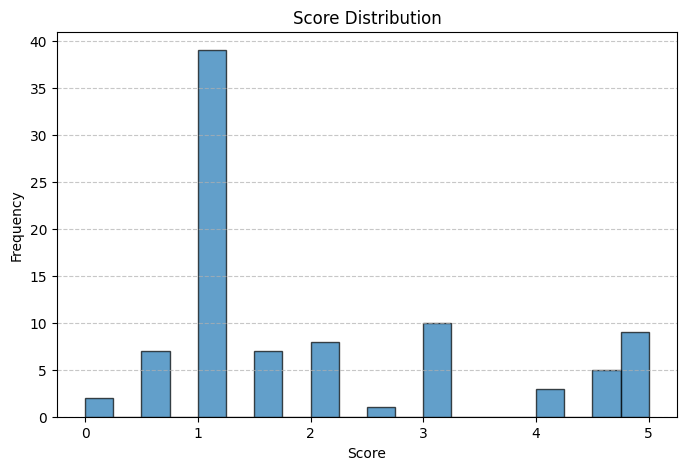

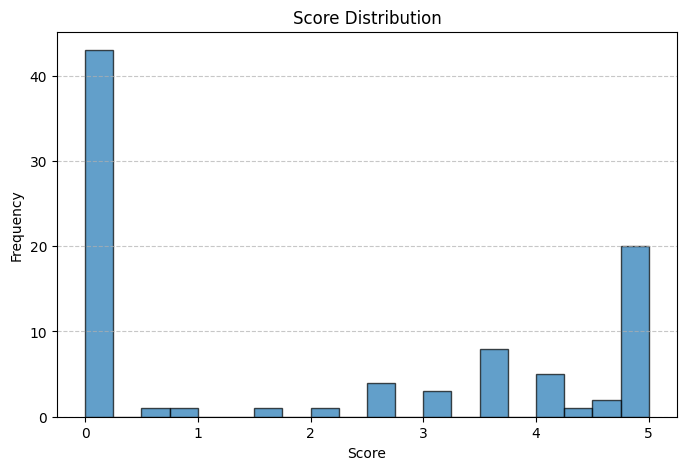

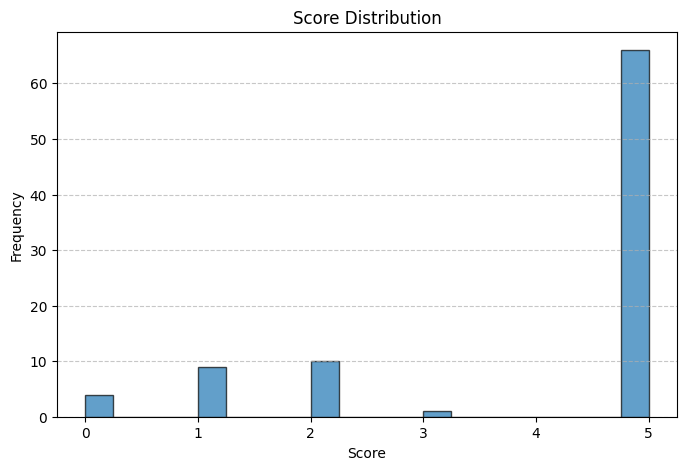

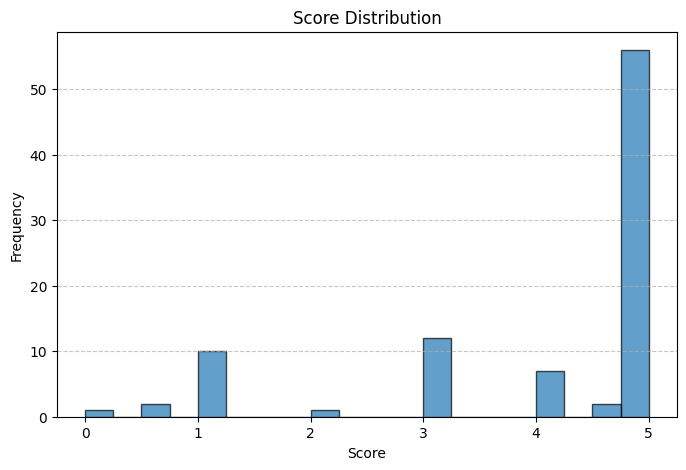

In [ ]:
Q1 = train_df[train_df['set'] == 'Q1'].drop(["ID", "set"], axis = 1)
Q2 = train_df[train_df['set'] == 'Q2'].drop(["ID", "set"], axis = 1)
Q3 = train_df[train_df['set'] == 'Q3'].drop(["ID", "set"], axis = 1)
Q4 = train_df[train_df['set'] == 'Q4'].drop(["ID", "set"], axis = 1)



def plot_hist_score(df):
    plt.figure(figsize=(8, 5))
    plt.hist(df['score'], bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('Score Distribution')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()




plot_hist_score(Q1)
plot_hist_score(Q2)
plot_hist_score(Q3)
plot_hist_score(Q4)

# Show questions

In [ ]:
q1 =  Q1["question"].iloc[0]
q2 =  Q2["question"].iloc[0]
q3 =  Q3["question"].iloc[0]
q4 =  Q4["question"].iloc[0]

questions = [q1, q2, q3, q4]

print(f"Main question : {questions[0][:269]}")
print()
for i, q in enumerate(questions):
    print(f"Question {i+1}: ")
    print(q[269:])

Main question : Hamtube เป็นแพลตฟอร์มดูวีดีโอออนไลน์ ที่อนุญาตให้ผู้ใช้อัปโหลด แชร์ และดูวิดีโอได้ แฮมทาโร่ เป็นหัวหน้าทีมการตลาดของ Hamtube และเขาต้องการทราบว่าการย้ายตำแหน่งของโฆษณาจะช่วยเพิ่มยอดขาย (ผู้ใช้คลิกโฆษณามากขึ้น) หรือไม่ ดังนั้นเขาตัดสินใจที่จะดำเนินการทดลอง A/B testing. 

Question 1: 
อธิบายเหตุผลที่แฮมทาโร่ควรใช้ A/B testing ในการทดสอบ หรือเสนอข้อโต้แย้งหากคุณไม่เห็นด้วย พร้อมกับอธิบายเหตุผล
Question 2: 
granularity ควรเป็นอะไร และความยาวของ attribution period ควรเป็นเท่าไหร่ จงอธิบายเหตุผล
Question 3: 
แฮมทาโร่เลือกที่จะใช้ binomial distribution เพื่อแทน distribution ของการทำ A/B testing ในครั้งนี้ คุณเห็นด้วยหรือไม่เห็นด้วยกับแฮมทาโร่ เพราะเหตุใด
Question 4: 
แฮมทาโร่จะต้องเลือกว่าอยากให้สัดส่วนของ user ที่เห็นโฆษณาตำแหน่งเก่า ต่อ user ที่เห็นโฆษณาตำแหน่งใหม่เป็นเท่าไร โดยตอนนี้แฮมทาโร่กำลังลังเลระหว่างสัดส่วน 50/50 กับ สัดส่วน 80/20 จงอธิบายข้อดีข้อเสียของการเลือกสัดส่วนแต่ละแบบ และตอบว่าแบบใดที่น่าจะเหมาะสมกับปัญหานี้มากกว่า


# Stupid baseline                                                             
### result = 5.82...   Very badd


### Answer based on max prob

In [ ]:
def generate_stupid_baseline(test_file, output_file="output_csv/stupid_baseline.csv"):
    """
    Generates a stupid baseline by assigning fixed scores to each question set.

    Parameters:
    - test_file (str): Path to the test dataset CSV.
    - output_file (str): Path to save the output CSV file.

    Returns:
    - None (baseline predictions are saved to a CSV file)
    """

    mapping = {"Q1": 1.0, "Q2": 0.0, "Q3": 5.0, "Q4": 5.0}

    test_df = pd.read_csv(test_file)

    stupid_baseline_df = test_df.copy()
    stupid_baseline_df["score"] = stupid_baseline_df["set"].map(mapping)

    # Drop unnecessary columns
    stupid_baseline_df = stupid_baseline_df.drop(["set", "question", "answer"], axis=1)

    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    # Save to CSV
    stupid_baseline_df.to_csv(output_file, index=False)
    print(f"Saved stupid baseline to {output_file}")


generate_stupid_baseline(test_path)

Saved stupid baseline to output_csv/stupid_baseline.csv


# Prob baseline
## result: 6.29 (worst than Stupid baseline)
### answer based on prob

In [ ]:

def generate_probabilistic_baseline(train_file, test_file, output_file="output_csv/prob_baseline.csv"):
    """
    Generates a probabilistic baseline by assigning scores based on the distribution of scores in the training data.

    Parameters:
    - train_file (str): Path to the training dataset CSV.
    - test_file (str): Path to the test dataset CSV.
    - output_file (str): Path to save the output CSV file.

    Returns:
    - None (baseline predictions are saved to a CSV file)
    """
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)

    # Compute the probability distribution of scores from training data
    score_counts = train_df["score"].value_counts(normalize=True)  # Normalized counts = probabilities

    # Generate probabilistic predictions for test set
    test_df["predicted_score"] = np.random.choice(
        score_counts.index,  # Possible score values
        size=len(test_df),  # Match test dataset size
        p=score_counts.values  # Assign probabilities based on training data
    )

    test_df[["ID", "predicted_score"]].to_csv(output_file, index=False)
    print(f"Saved probabilistic baseline to {output_file}")


generate_probabilistic_baseline(train_path, test_path)

Saved probabilistic baseline to output_csv/prob_baseline.csv


# BERT
try all embedding models

Best: 2.30

In [ ]:
# Define multiple BERT models for comparison
BERT_MODELS = {
    "miniLM": "paraphrase-MiniLM-L6-v2",
    "mpnet": "all-mpnet-base-v2",
    "roberta": "roberta-large-nli-stsb-mean-tokens"
}

def train_bert_models(train_file, model_dir="models"):
    """
    Train separate Ridge regression models for each BERT model and question set.

    Parameters:
    - train_file (str): Path to the training dataset CSV.
    - model_dir (str): Directory to save trained models.

    Returns:
    - None (models are saved)
    """
    print(f"Loading training data from {train_file}...")
    train_df = pd.read_csv(train_file)
    train_df["combined_text"] = train_df["question"] + " " + train_df["answer"]

    os.makedirs(model_dir, exist_ok=True)

    for bert_key, bert_model_name in BERT_MODELS.items():
        print(f"\nLoading BERT model: {bert_model_name}")
        bert_model = SentenceTransformer(bert_model_name)

        for question_set in train_df["set"].unique():
            print(f"\nTraining Ridge model for Question Set: {question_set} using {bert_key} embeddings")

            subset = train_df[train_df["set"] == question_set]
            X_train = bert_model.encode(subset["combined_text"].tolist(), convert_to_numpy=True)
            y_train = subset["score"]

            regressor = Ridge(alpha=1.0)
            regressor.fit(X_train, y_train)

            model_path = os.path.join(model_dir, f"{bert_key}_regressor_{question_set}.pkl")
            joblib.dump(regressor, model_path)
            print(f"Saved Ridge model using {bert_key}: {model_path}")

    print("\nTraining complete. All models saved.")

def load_valid_scores(train_file):
    """
    Extracts unique valid scores from the training data to ensure predictions are discrete.

    Parameters:
    - train_file (str): Path to the training dataset CSV.

    Returns:
    - List of valid scores sorted in ascending order.
    """
    train_df = pd.read_csv(train_file)
    return sorted(train_df["score"].unique())

def round_to_nearest_valid(value, valid_scores):
    """
    Rounds a given value to the nearest valid score.

    Parameters:
    - value (float): Predicted continuous score.
    - valid_scores (list): List of allowed discrete scores.

    Returns:
    - Nearest valid score.
    """
    return min(valid_scores, key=lambda x: abs(x - value))

def predict_bert_scores(test_file, train_file, model_dir="models", output_dir="output_csv"):
    """
    Predict scores using multiple BERT embeddings and compare results.

    Parameters:
    - test_file (str): Path to the test dataset CSV.
    - train_file (str): Path to the training dataset CSV (to extract valid scores).
    - model_dir (str): Directory where trained models are stored.
    - output_dir (str): Directory to save the output CSV files.

    Returns:
    - None (predictions are saved)
    """
    print(f"Loading test data from {test_file}...")
    test_df = pd.read_csv(test_file)
    test_df["combined_text"] = test_df["question"] + " " + test_df["answer"]

    valid_scores = load_valid_scores(train_file)
    print(f"Valid scores: {valid_scores}")

    os.makedirs(output_dir, exist_ok=True)

    for bert_key, bert_model_name in BERT_MODELS.items():
        print(f"\nLoading BERT model: {bert_model_name}")
        bert_model = SentenceTransformer(bert_model_name)

        print(f"\nPredicting using {bert_key} embeddings...")
        predictions = []

        for _, row in test_df.iterrows():
            question_set = row["set"]
            text_embedding = bert_model.encode([row["combined_text"]], convert_to_numpy=True)

            model_path = os.path.join(model_dir, f"{bert_key}_regressor_{question_set}.pkl")
            if os.path.exists(model_path):
                model = joblib.load(model_path)
                raw_prediction = model.predict(text_embedding)[0]
                predicted_score = round_to_nearest_valid(raw_prediction, valid_scores)
            else:
                predicted_score = np.nan

            predictions.append(predicted_score)

        output_df = test_df[["ID"]].copy()
        output_df["score"] = predictions

        output_file = os.path.join(output_dir, f"{bert_key}_predicted_scores.csv")
        output_df.to_csv(output_file, index=False)
        print(f"Predictions saved for {bert_key} model: {output_file}")

# ===============================
# RUN TRAINING AND PREDICTION
# ===============================


# train_bert_models(train_path)
# predict_bert_scores(test_path, train_path)

# **Final version**

# **Data augmentation**

In [ ]:
!pip install googletrans==4.0.0-rc1

from googletrans import Translator

# Initialize the translator
translator = Translator()

def back_translate(text):
    """Translates text from Thai to English and back to Thai."""
    try:
        translated = translator.translate(text, src="th", dest="en").text
        back_translated = translator.translate(translated, src="en", dest="th").text
        return back_translated.replace("\n", "")
    except:
        return text  # Return original text if translation fails




y_train_Q1 = Q1["score"].to_numpy()
y_train_Q2 = Q2["score"].to_numpy()
y_train_Q3 = Q3["score"].to_numpy()
y_train_Q4 = Q4["score"].to_numpy()



X_train_Q1 = Q1["answer"].to_numpy()
X_train_Q2 = Q2["answer"].to_numpy()
X_train_Q3 = Q3["answer"].to_numpy()
X_train_Q4 = Q4["answer"].to_numpy()

# Vectorize the back_translate function to apply it element-wise
vectorized_back_translate = np.vectorize(back_translate)

# Apply back translation to each dataset
X_train_Q1_back = vectorized_back_translate(X_train_Q1)
X_train_Q2_back = vectorized_back_translate(X_train_Q2)
X_train_Q3_back = vectorized_back_translate(X_train_Q3)
X_train_Q4_back = vectorized_back_translate(X_train_Q4)


X_train_Q1 = np.concatenate((X_train_Q1, X_train_Q1_back))
X_train_Q2 = np.concatenate((X_train_Q2, X_train_Q2_back))
X_train_Q3 = np.concatenate((X_train_Q3, X_train_Q3_back))
X_train_Q4 = np.concatenate((X_train_Q4, X_train_Q4_back))

y_train_Q1 = np.concatenate((y_train_Q1, y_train_Q1))
y_train_Q2 = np.concatenate((y_train_Q2, y_train_Q2))
y_train_Q3 = np.concatenate((y_train_Q3, y_train_Q3))
y_train_Q4 = np.concatenate((y_train_Q4, y_train_Q4))


In [ ]:
# Install required libraries
!pip install transformers datasets pythainlp torch scikit-learn

import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder

# Load ThaiBERT tokenizer and model
MODEL_NAME = "airesearch/wangchanberta-base-att-spm-uncased"  # Ensure the correct model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

# Merge all questions into a single dataset
X_train = np.concatenate((X_train_Q1, X_train_Q2, X_train_Q3, X_train_Q4))
y_train = np.concatenate((y_train_Q1, y_train_Q2, y_train_Q3, y_train_Q4))
question_labels = np.array(["Q1"] * len(X_train_Q1) +
                           ["Q2"] * len(X_train_Q2) +
                           ["Q3"] * len(X_train_Q3) +
                           ["Q4"] * len(X_train_Q4))

# One-hot encode the question sets
encoder = OneHotEncoder(sparse_output=False)
question_set_encoded = encoder.fit_transform(question_labels.reshape(-1, 1))

# Train-test split
X_train, X_val, y_train, y_val, q_train, q_val = train_test_split(
    X_train, y_train, question_set_encoded, test_size=0.2, random_state=42
)

# Convert text to BERT embeddings
def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.last_hidden_state.mean(dim=1).squeeze().numpy()

X_train_bert = np.array([get_bert_embedding(text) for text in X_train])
X_val_bert = np.array([get_bert_embedding(text) for text in X_val])

# Concatenate BERT embeddings with question set encodings
X_train_final = np.concatenate((X_train_bert, q_train), axis=1)
X_val_final = np.concatenate((X_val_bert, q_val), axis=1)

class ThaiBERTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Convert data to Pytorch Dataset
train_dataset = ThaiBERTDataset(X_train_final, y_train)
val_dataset = ThaiBERTDataset(X_val_final, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define Regression Model (Modified to accept extra question set features)
class ThaiBERTRegressor(nn.Module):
    def __init__(self, input_dim):
        super(ThaiBERTRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Input = BERT (768) + One-hot encoding (4) = 772
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)  # Regression output
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ThaiBERTRegressor(input_dim=772).to(device)  # 768 + 4
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

train(model, train_loader, val_loader, criterion, optimizer, epochs=10)
torch.save(model.state_dict(), "thaibert_regressor_with_qset.pth")

def predict(text, question_set):
    model.eval()

    # Convert text to BERT embedding
    bert_embedding = get_bert_embedding(text).reshape(1, -1)

    # One-hot encode the question set
    q_encoded = encoder.transform([[question_set]])

    # Concatenate and predict
    input_features = np.concatenate((bert_embedding, q_encoded), axis=1)
    input_tensor = torch.tensor(input_features, dtype=torch.float32).to(device)

    with torch.no_grad():
        prediction = model(input_tensor).squeeze().cpu().numpy()

    return prediction

print("Predicted Score:", predict("นักเรียนสามารถทำการบ้านได้ดี", "Q1"))


Epoch 1, Loss: 7.2475
Epoch 2, Loss: 3.9255
Epoch 3, Loss: 3.6315
Epoch 4, Loss: 3.4695
Epoch 5, Loss: 3.1106
Epoch 6, Loss: 2.9679
Epoch 7, Loss: 2.8651
Epoch 8, Loss: 2.8366
Epoch 9, Loss: 2.7347
Epoch 10, Loss: 2.7340
Predicted Score: -0.43324995


In [ ]:


test_df = pd.read_csv("/content/data/test.csv")
X_test = test_df["answer"].to_numpy()
question_labels_test = test_df["set"].to_numpy()  # Assuming "set" column contains Q1, Q2, etc.

question_set_encoded_test = encoder.transform(question_labels_test.reshape(-1, 1))

# Convert test answers to ThaiBERT embeddings
X_test_bert = np.array([get_bert_embedding(text) for text in X_test])

# Concatenate embeddings with question encodings
X_test_final = np.concatenate((X_test_bert, question_set_encoded_test), axis=1)

# Convert to tensor for model prediction
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32).to(device)

# Load trained model
model.load_state_dict(torch.load("thaibert_regressor_with_qset.pth"))
model.eval()

# Predict test scores
with torch.no_grad():
    y_test_pred = model(X_test_tensor).squeeze().cpu().numpy()

# Create submission DataFrame
submission_df = pd.DataFrame({
    "ID": test_df["ID"],  # Ensure ID matches test_df
    "score": y_test_pred
})

# Save predictions as CSV
submission_df.to_csv("output_csv/submission.csv", index=False)

print("✅ Predictions saved as submission.csv")

✅ Predictions saved as submission.csv
